In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ratings = pd.read_csv('/content/ml_latest_small/ratings.csv')

In [3]:
movies = pd.read_csv('/content/ml_latest_small/movies.csv')

In [4]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {(n_ratings/n_users)}")
print(f"Average number of ratings per movie: {(n_ratings/n_movies)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.30491803278687
Average number of ratings per movie: 10.369806663924312


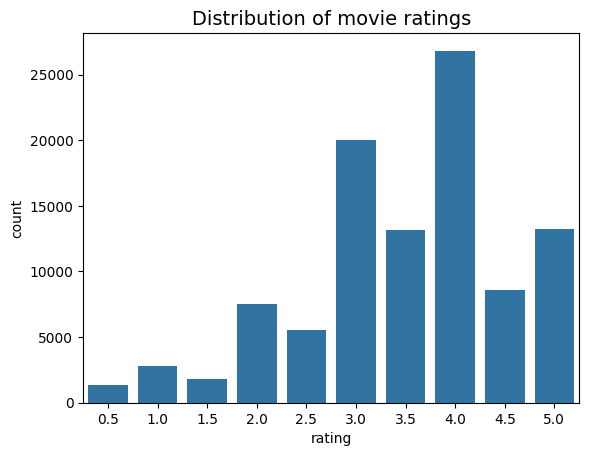

In [5]:
sns.countplot(x='rating', data=ratings)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [6]:
print(f"Mean global rating: {(ratings['rating'].mean())}.")

Mean global rating: 3.501556983616962.


In [7]:
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {(mean_ratings.mean())}.")

Mean rating per user: 3.6572223377474.


In [8]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings.head(10)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War


In [9]:
movie_ratings['title'].value_counts()[0:10]

,count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


In [10]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()

movies[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [11]:
ratings[ratings['movieId']==lowest_rated]         # Gypsy is lowest rated, but it has only 1 rating

,userId,movieId,rating,timestamp
13633,89,3604,0.5,1520408880


In [12]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [13]:
ratings[ratings['movieId']==highest_rated]   # Lamerica may be the highest rated movie, but it only has 2 ratings.

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


In [14]:
movie_stat = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stat.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [15]:
'''Lets check Bayesian Average which is C*m + total_reviews/(C + total number of reviews for movie  i), where  C  represents our confidence,  m  represents our prior.'''

C = movie_stat['count'].mean()
m = movie_stat['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m + ratings.sum())/(C + ratings.count())
    return round(bayesian_avg, 3)

In [16]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stat = movie_stat.merge(bayesian_avg_ratings, on='movieId')
movie_stat.head()

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.891
1,2,110,3.431818,3.417
2,3,52,3.259615,3.260
3,4,7,2.357143,2.898
4,5,49,3.071429,3.105


In [17]:
movie_stat = movie_stat.merge(movies[['movieId', 'title']])
movie_stat.sort_values(by='bayesian_avg', ascending=False)

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"
...,...,...,...,...,...
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1372,1882,33,1.954545,2.267,Godzilla (1998)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)


In [22]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [23]:
# How many movie genres are there?
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [24]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


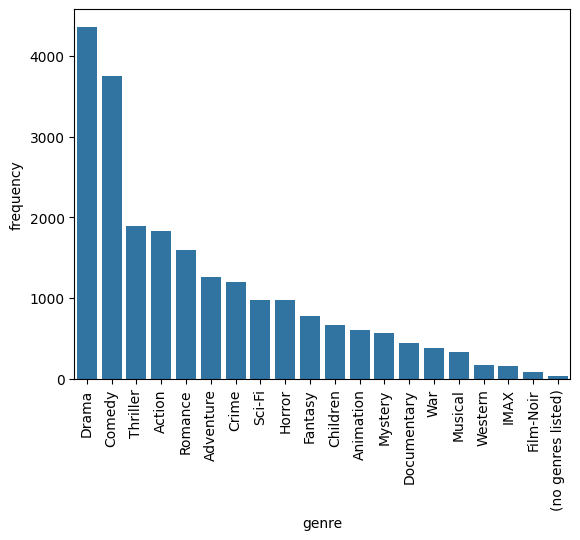

In [25]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'frequency']
sns.barplot(x='genre', y='frequency', data=genre_frequency_df.sort_values(by='frequency', ascending=False))
plt.xticks(rotation=90)
plt.show()

In [26]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Args:
        df: dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        a sparse matrix X (user-item matrix) with four mapper dictionaries:
        user_mapper: maps user id to user index
        movie_mapper: maps movie id to movie index
        user_inv_mapper: maps user index to user id
        movie_inv_mapper: maps movie index to movie id
        We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [27]:
# calculate sparsity by dividing the number of stored elements by total number of elements.
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz      # The number of stored (non-zero) elements in our matrix (nnz) is equivalent to the number of ratings in our dataset.
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


In [28]:
# In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.
n_ratings_per_user = X.getnnz(axis=1)
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [29]:
n_ratings_per_movie = X.getnnz(axis=0)
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


In [30]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id meaning to find k movies that have the most similar user engagement vectors for movie i.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [31]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)  # the kNN distance metric can be changed for different outputs
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}, recommendations below should be of interest:")
for i in similar_movies:
  print(movie_titles[i])

Because you watched Toy Story (1995), recommendations below should be of interest:
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


In [32]:
'''The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system.
First, we need to convert the genres column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1.'''

genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] =movies['genres'].apply(lambda x: int(g in x))

movies.head()

,movieId,title,genres,Comedy,Action,War,Western,Drama,Mystery,Sci-Fi,...,Children,IMAX,Horror,Adventure,Film-Noir,Documentary,Crime,Musical,Thriller,(no genres listed)
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
movie_genres = movies.drop(columns=['movieId', 'title','genres'])
movie_genres.head()

,Comedy,Action,War,Western,Drama,Mystery,Sci-Fi,Animation,Romance,Fantasy,Children,IMAX,Horror,Adventure,Film-Noir,Documentary,Crime,Musical,Thriller,(no genres listed)
0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(movie_genres, movie_genres)
'''After passing the movie_genres dataframe into the cosine_similarity() function, we get a cosine similarity matrix of shape (n_movies,n_movies),
this matrix is populated with values between 0 and 1 which represent the degree of similarity between movies along the x and y axes.'''
cosine_sim.shape


(9742, 9742)

In [49]:
'''Let's say we want to get recommendations for movies that are similar to Godfather. To get results from our recommender, we need to know the exact title of a movie in our dataset.

In our dataset, Godfather is actually listed as 'Godfather, The (1972)'. If we misspell Godfather or forget to include its year of release, our recommender won't be able to identify which movie we're interested in.

To make our recommender more user-friendly, we can use a Python package called fuzzywuzzy which will find the most similar title to a string that we pass in.'''

!pip install fuzzywuzzy==0.18.0
from fuzzywuzzy import process
def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

In [50]:
title = movie_finder('godfaer')
title

'Godfather, The (1972)'

In [51]:
'''To get relevant recommendations for Godfather, we need to find its index in the cosine simialrity matrix.
To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix.'''

movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Godfather: {idx}")

Movie index for Godfather: 659


In [52]:
# picking out the row with similar movie comparisons to Godfather(index 659)
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]  # not from 0 because 0 is for Godfather
similar_movies = [i[0] for i in sim_scores]
similar_movies

[29, 33, 86, 102, 211, 245, 251, 277, 348, 354]

In [53]:
print(f"Because you watched {title}, recommendations below should be of interest:")
movies['title'].iloc[similar_movies]

Because you watched Godfather, The (1972), recommendations below should be of interest:


,title
29,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
33,Dead Man Walking (1995)
86,"Hate (Haine, La) (1995)"
102,"Young Poisoner's Handbook, The (1995)"
211,Heavenly Creatures (1994)
245,New Jersey Drive (1995)
251,Once Were Warriors (1994)
277,"Shawshank Redemption, The (1994)"
348,Jason's Lyric (1994)
354,Above the Rim (1994)


In [60]:
# Overall functionalities combined in the below function
def get_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title} the recommendations below should be of interest:")
    print(movies['title'].iloc[similar_movies])

In [61]:
get_recommendations('lion king', 5)

Because you watched Lion King, The (1994) the recommendations below should be of interest:
1273                                     Anastasia (1997)
673     Land Before Time III: The Time of the Great Gi...
786                                          Dumbo (1941)
787                                  Pete's Dragon (1977)
1562                             Song of the South (1946)
Name: title, dtype: object


In [59]:
'''Matrix factorisation is particularly useful for very sparse data and can enhance the quality of recommendations.
The algorithm works by factorizing the original user-item matrix into two factor matrices:

user-factor matrix (n_users, k)
item-factor matrix (k, n_items)  k here can include feature like romance, comedy, independent foreign language films etc.
We are basically reducing the dimensions of our original matrix'''

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)    # We can think of each component representing a latent feature such as movie genre.
Q = svd.fit_transform(X.T)
Q.shape

(9724, 20)

In [65]:
godfather_movie = movies[movies['title'] == 'Godfather, The (1972)']['movieId'].iloc[0]
godfather_movie

np.int64(858)

In [66]:
# Lets check for the movie Godfather
movie_id = 858
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}, the recommendations below should be of interest: ")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Godfather, The (1972), the recommendations below should be of interest: 
Godfather: Part II, The (1974)
Goodfellas (1990)
One Flew Over the Cuckoo's Nest (1975)
Reservoir Dogs (1992)
Fargo (1996)
American Beauty (1999)
Usual Suspects, The (1995)
L.A. Confidential (1997)
Sixth Sense, The (1999)


In [67]:
def get_collaborative_recommendations(title_string, X, Q, movie_mapper, movie_inv_mapper, movies_df, k=10, metric='cosine'):

    exact_title = movie_finder(title_string)
    movie_id = movies_df[movies_df['title'] == exact_title]['movieId'].iloc[0]
    similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, k=k, metric=metric)
    movie_title = movies_df[movies_df['movieId'] == movie_id]['title'].iloc[0]

    print(f"Because you watched {movie_title}, the recommendations below should be of interest: ")
    movie_titles_dict = dict(zip(movies_df['movieId'], movies_df['title']))
    for i in similar_movies:
        print(movie_titles_dict[i])

In [68]:
get_collaborative_recommendations('godfather', X, Q, movie_mapper, movie_inv_mapper, movies, k=10, metric='cosine')

Because you watched Godfather, The (1972), the recommendations below should be of interest: 
Godfather: Part II, The (1974)
Goodfellas (1990)
One Flew Over the Cuckoo's Nest (1975)
Reservoir Dogs (1992)
Fargo (1996)
American Beauty (1999)
Usual Suspects, The (1995)
L.A. Confidential (1997)
Sixth Sense, The (1999)
